In [1]:
import pandas as pd
from itables import show
import numpy as np
import pandas as pd

from pycaret.time_series import TSForecastingExperiment

import pytimetk as tk
from prophet.plot import add_changepoints_to_plot
from prophet import Prophet

# análise de estacionariedade da série temporal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import zivot_andrews
from statsmodels.tsa.stattools import kpss


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


import seaborn as sns
import warnings
import os

%matplotlib inline
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"
warnings.filterwarnings(action="ignore")

# percentual para divisão entre dados de treino e teste
TRAIN_PERC: float = 0.75


# Lendo e tratando os dados

In [2]:
# Lê os dados de entrada
df = pd.read_csv("../../data/Ibovespa_20100101-20240224.csv")
show(df)


In [3]:
# corrige os tipos de dados
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3503 non-null   object 
 1   Último    3503 non-null   float64
 2   Abertura  3503 non-null   float64
 3   Máxima    3503 non-null   float64
 4   Mínima    3503 non-null   float64
 5   Vol.      3502 non-null   object 
 6   Var%      3503 non-null   object 
dtypes: float64(4), object(3)
memory usage: 191.7+ KB


In [4]:
def vol_to_numeric_value(s: str) -> float:
    """
    Transforma o valor de volume em float

    Args:
        s (str): valor de volume

    Returns:
        float: valor de volume em float
    """
    # if contains M, then multiply by 1.000.000
    if "M" in s:
        return float(s.replace("M", "")) * 1_000_000
    # if contains B, then multiply by 1.000.000.000
    elif "B" in s:
        return float(s.replace("B", "")) * 1_000_000_000
    elif "K" in s:
        return int(float(s.replace("K", ""))) * 1_000
    else:
        return np.nan


# corrige os tipos de dados
df["Data"] = pd.to_datetime(df["Data"])
df["Vol."] = df["Vol."].apply(lambda x: vol_to_numeric_value(str(x).replace(",", ".")))
df["Var%"] = df["Var%"].apply(lambda x: float(x.replace(",", ".").split("%")[0]) / 100)
df.set_index("Data", inplace=True)


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3503 entries, 2024-02-23 to 2010-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    3503 non-null   float64
 1   Abertura  3503 non-null   float64
 2   Máxima    3503 non-null   float64
 3   Mínima    3503 non-null   float64
 4   Vol.      3502 non-null   float64
 5   Var%      3503 non-null   float64
dtypes: float64(6)
memory usage: 191.6 KB


# EDA

In [6]:
cm = sns.light_palette("gray", as_cmap=True)
df.head(20).style.background_gradient(cmap=cm)


In [7]:
df.head()


Último  Abertura   Máxima   Mínima        Vol.    Var%
Data                                                               
2024-02-23  129.419   130.240  130.624  129.077   9230000.0 -0.0063
2024-02-22  130.241   130.035  130.829  129.971  10770000.0  0.0016
2024-02-21  130.032   129.916  130.034  129.359  12590000.0  0.0009
2024-02-20  129.916   129.033  129.916  128.326  12240000.0  0.0068
2024-02-19  129.036   128.720  129.036  128.097   5800000.0  0.0024

In [8]:
df.tail()


Último  Abertura  Máxima  Mínima       Vol.    Var%
Data                                                           
2010-01-08  70.263    70.455  70.766  70.158  1630000.0 -0.0027
2010-01-07  70.451    70.723  70.723  70.045  1550000.0 -0.0039
2010-01-06  70.729    70.237  70.937  70.016  2240000.0  0.0070
2010-01-05  70.240    70.046  70.595  69.928  1980000.0  0.0028
2010-01-04  70.045    68.587  70.081  68.587  1660000.0  0.0212

In [9]:
close_df = df[["Último"]]  # Select the "Close" column
close_df.rename(columns={"Último": "Close"}, inplace=True)
close_df = close_df.asfreq("d")
# close_df = close_df.asfreq("M")
close_df.fillna(method="ffill", inplace=True)


In [10]:
close_df = close_df.loc["2018-01-01":]


In [11]:
close_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2245 entries, 2018-01-01 to 2024-02-23
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2245 non-null   float64
dtypes: float64(1)
memory usage: 35.1 KB


In [12]:
print(close_df.head())
print(close_df.tail())


             Close
Data              
2018-01-01  76.402
2018-01-02  77.891
2018-01-03  77.995
2018-01-04  78.647
2018-01-05  79.071
              Close
Data               
2024-02-19  129.036
2024-02-20  129.916
2024-02-21  130.032
2024-02-22  130.241
2024-02-23  129.419


In [13]:
close_df.describe()


Close
count  2245.000000
mean    104.304033
std      14.722484
min      63.570000
25%      95.479000
50%     106.042000
75%     115.313000
max     134.194000

## EDA pytimetk

In [14]:
tk_close = close_df.reset_index()
tk_close.glimpse()


<class 'pandas.core.frame.DataFrame'>: 2245 rows of 2 columns
Data:   datetime64[ns]    [Timestamp('2018-01-01 00:00:00'), Timestamp(' ...
Close:  float64           [76.402, 77.891, 77.995, 78.647, 79.071, 79.07 ...


In [15]:
tk.ts_summary(tk_close, date_column="Data").T


0
date_n                                2245
date_tz                               None
date_start             2018-01-01 00:00:00
date_end               2024-02-23 00:00:00
freq_inferred_unit                       D
freq_median_timedelta      1 days 00:00:00
freq_median_scale                      1.0
freq_median_unit                         D
diff_min                   1 days 00:00:00
diff_q25                   1 days 00:00:00
diff_median                1 days 00:00:00
diff_mean                  1 days 00:00:00
diff_q75                   1 days 00:00:00
diff_max                   1 days 00:00:00
diff_min_seconds                   86400.0
diff_q25_seconds                   86400.0
diff_median_seconds                86400.0
diff_mean_seconds                  86400.0
diff_q75_seconds                   86400.0
diff_max_seconds                   86400.0

In [16]:
tk.plot_timeseries(
    data=tk_close,
    date_column="Data",
    value_column="Close",
    title="Close",
    width=800,
    height=600,
    smooth=0.2,
)


### Decomposição de componentes e detecção de anomalias

In [64]:
anomalize_df = tk_close.anomalize(
    date_column="Data", value_column="Close", iqr_alpha=0.05
)
anomalize_df.glimpse()


<class 'pandas.core.frame.DataFrame'>: 2245 rows of 12 columns
Data:               datetime64[ns]    [Timestamp('2018-01-01 00:00:00'), ...
observed:           float64           [76.402, 77.891, 77.995, 78.647, 7 ...
seasonal:           float64           [-0.6953419611247764, -0.143479561 ...
seasadj:            float64           [77.09734196112478, 78.03447956181 ...
trend:              float64           [78.65126316630274, 78.78250387559 ...
remainder:          float64           [-1.5539212051779572, -0.748024313 ...
anomaly:            object            ['No', 'No', 'No', 'No', 'No', 'No ...
anomaly_score:      float64           [2.9079155146478968, 2.10201862324 ...
anomaly_direction:  int64             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  ...
recomposed_l1:      float64           [71.14838676766425, 71.83148987626 ...
recomposed_l2:      float64           [87.47144426163155, 88.15454737022 ...
observed_clean:     float64           [76.402, 77.891, 77.995, 78.647, 7 ...


In [65]:
anomalize_df.plot_anomalies_decomp(
    date_column="Data", width=800, height=1000, engine="plotly"
)


A decomposição da séries em suas componentes de sazonalidade, tendência e resíduos demonstra que a séries provavelmente não é estacionária. Porém, para se verficar formalmente a afirmação anterior, podemos aplicar os testes para verificar a existência ou não de raízes unitárias.

#### Testando a existência de raízes unitárias

In [19]:
from colorama import Fore


def uroot(timeseries):
    print("\n**********************************")
    print("Resultados do Teste Dickey-Fuller Aumentado:")
    print("H0: A série possui raiz unitária")
    print("H1: A série não possui raiz unitária\n")
    dftest = adfuller(timeseries, autolag="AIC", regression="ct")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    print(dfoutput)
    if np.abs(dfoutput[1] < 0.05):
        print(
            Fore.GREEN
            + "\nResultado: H0 é rejeitada. Processo é estacionário."
            + Fore.RESET
        )
    else:
        print(
            Fore.RED
            + "\nResultado: H0 não é rejeitada. Processo não é estacionário."
            + Fore.RESET
        )

    print("\n**********************************")
    print("Resultados do Teste KPSS Test:")
    print("H0: O processo é tendência-estacionário")
    print("H1: A série possui raiz unitária\n")
    kpsstest = kpss(timeseries, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "#Lags Used"]
    )
    print(kpss_output)
    if np.abs(kpss_output[1] < 0.05):
        print(
            Fore.RED
            + "\nResultado: H0 é rejeitada. Processo não é estacionário."
            + Fore.RESET
        )
    else:
        print(
            Fore.GREEN
            + "\nResultado: H0 não é rejeitada. Processo é estacionário."
            + Fore.RESET
        )

    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    Fore.RESET

    print("\n**********************************")
    print("Results of Zivot-Andrews Test:")
    print("H0: A série possui raiz unitária em decorrência de um quebra estrutural")
    print("H1: A série não possui raiz unitária\n")
    zatest = zivot_andrews(timeseries, regression="ct", autolag="AIC")
    za_output = list(zatest[0:2])
    za_output.append(zatest[3])
    za_output = pd.Series(za_output, index=["Test Statistic", "p-value", "#Lags Used"])

    for key, value in zatest[2].items():
        za_output["Critical Value (%s)" % key] = value
    print(za_output)
    if np.abs(za_output[1] < 0.05):
        print(
            Fore.GREEN
            + "\nResultado: H0 é rejeitada. Processo é estacionário."
            + Fore.RESET
        )
    else:
        print(
            Fore.RED
            + "\nResultado: H0 não é rejeitada. Processo não é estacionário."
            + Fore.RESET
        )


uroot(close_df.copy())



**********************************
Resultados do Teste Dickey-Fuller Aumentado:
H0: A série possui raiz unitária
H1: A série não possui raiz unitária



Test Statistic                   -3.288433
p-value                           0.068176
#Lags Used                       12.000000
Number of Observations Used    2232.000000
Critical Value (1%)              -3.962832
Critical Value (5%)              -3.412459
Critical Value (10%)             -3.128209
dtype: float64

Resultado: H0 não é rejeitada. Processo não é estacionário.

**********************************
Resultados do Teste KPSS Test:
H0: O processo é tendência-estacionário
H1: A série possui raiz unitária

Test Statistic     0.413226
p-value            0.010000
#Lags Used        29.000000
dtype: float64

Resultado: H0 é rejeitada. Processo não é estacionário.

**********************************
Results of Zivot-Andrews Test:
H0: A série possui raiz unitária em decorrência de um quebra estrutural
H1: A série não possui raiz unitária

Test Statistic          -3.952765
p-value                  0.535726
#Lags Used              12.000000
Critical Value (1%)     -5.575560
Critical Valu

Como esperado, para os testes de raízes unitárias, considerando que a séries possui tendência e _drift_, se tem que o processo é não estacionário. Deste modo, a modelagem da série utilizando modelos tradicionais, como os da família ARIMA, não são indicados para a série em nível, pois pressupõe a inexitência de raízes unitárias.

Por outro lado, é possível identificar a ordem de integração da série, ou seja, quantas diferenciações seriam necessárias para tornar a série estacionária.

In [20]:
diff_close_df = close_df.copy().diff().dropna()

uroot(diff_close_df)



**********************************
Resultados do Teste Dickey-Fuller Aumentado:
H0: A série possui raiz unitária
H1: A série não possui raiz unitária

Test Statistic                -1.206721e+01
p-value                        2.996344e-19
#Lags Used                     1.100000e+01
Number of Observations Used    2.232000e+03
Critical Value (1%)           -3.962832e+00
Critical Value (5%)           -3.412459e+00
Critical Value (10%)          -3.128209e+00
dtype: float64

Resultado: H0 é rejeitada. Processo é estacionário.

**********************************
Resultados do Teste KPSS Test:
H0: O processo é tendência-estacionário
H1: A série possui raiz unitária

Test Statistic    0.035117
p-value           0.100000
#Lags Used        1.000000
dtype: float64

Resultado: H0 não é rejeitada. Processo é estacionário.

**********************************
Results of Zivot-Andrews Test:
H0: A série possui raiz unitária em decorrência de um quebra estrutural
H1: A série não possui raiz unitária

T

Pelo resultado acima podemos verificar que a série é integrada de ordem I(1). Isto significa que ela precisa de uma diferenciação para se tornar estacionária.

### Visualização das anomalias e identificação de choques

In [66]:
anomalize_df.plot_anomalies(date_column="Data", width=1000, height=500, engine="plotly")


Visualização da série sem anomalias 

In [63]:
anomalize_df.plot_anomalies_cleaned(
    date_column="Data", width=1000, height=500, engine="plotly"
)


In [23]:
tk_df_clean = anomalize_df[["Data", "observed_clean"]].rename(
    {"observed_clean": "Close"}
)


# Modelo ARIMA

O uso do modelo ARIMA serve como _benchmark_ para avaliar a capacidade preditiva de modelos mais  avançados, tais como o Prophet e outros baseados em técnicas de _machine-learning_. 

Neste caso iremos utilizar a biblioteca __pmdarima__, a qual faz uso do algoritmo proposto por Hyndman, e implementado inicialmente em R por meio da biblioteca __auto.arima__. 

### Autocorrelação e Autocorrelação Parcial

|Pattern	|Likely Model Type|	Explanation
| ---|---|---|
| ACF decays slowly, PACF cuts off after a few lags|	AR (Autoregressive)	| Current values are significantly influenced by past values|
| ACF cuts off after a few lags, PACF decays slowly|	MA (Moving Average)	|Current values are influenced by past error terms|
|Both ACF and PACF decay slowly	|ARMA (Mixed)|	Current values are influenced by a combination of past values and error terms|

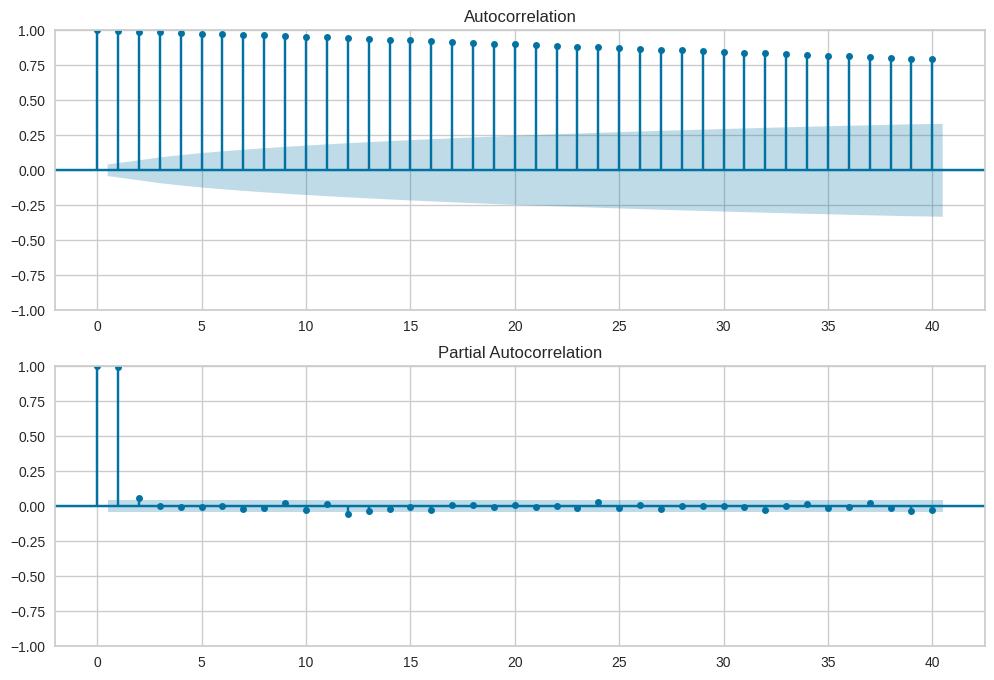

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(close_df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(close_df, lags=40, ax=ax2)


- AR Model: The ACF shows a slow, gradual decay while the PACF has a sharp cutoff after one or two lags.

### Testes de raiz unitária

Na seção anterior foram realizados testes para identificação de raízes unitárias (ADF, KPSS e Zivot-Andrews) os quais apontaram para a não estacionariedade da série em questão.

Existe outro teste que pode ser realizado, que é o Phillips-Peron:

In statistics, the Phillips–Perron test (named after Peter C. B. Phillips and Pierre Perron) is a unit root test. It is used in time series analysis to test the null hypothesis that a time series is integrated of order 1. It builds on the Dickey–Fuller test of the null hypothesis p = 0.

In [25]:
from pmdarima.arima.stationarity import PPTest

pp_test = PPTest(alpha=0.05)
pptest = pp_test.should_diff(close_df.copy())
print("\n************************************")
print("Resultados do Teste de Phillips-Peron:")
print("H0: A série é integrada de ordem 1 - I(1)")
print("H1: A série não é integrada de ordem 1 - I(1)\n")
ppoutput = pd.Series(pptest[0], index=["p-value"])
print(ppoutput)
if pptest[1] == True:
    print(Fore.RED + "\nResultado: o processo é não estacionário." + Fore.RESET)
else:
    print(Fore.GREEN + "\nResultado: o processo é estacionário." + Fore.RESET)



************************************
Resultados do Teste de Phillips-Peron:
H0: A série é integrada de ordem 1 - I(1)
H1: A série não é integrada de ordem 1 - I(1)

p-value    0.163099
dtype: float64

Resultado: o processo é não estacionário.


In [26]:
from pmdarima.arima.utils import ndiffs, nsdiffs

print("\n***********************************************************")
print("Ordem de Integração (d) de acordo com os testes ADF, KPSS e PP:\n")
n_diffs = [ndiffs(close_df.copy(), test=t) for t in ("adf", "kpss", "pp")]
n_diffs = pd.Series(n_diffs, index=["d-ADF", "d-KPSS", "d-PP"])
print(n_diffs)


print("\n***********************************************************")
print("Ordem de Integração do termo sazonal (D) de acordo com o teste ch:\n")
print(f"D {nsdiffs(close_df.copy(),  m=7, test=('ch'))}")



***********************************************************
Ordem de Integração (d) de acordo com os testes ADF, KPSS e PP:

d-ADF     1
d-KPSS    1
d-PP      1
dtype: int64

***********************************************************
Ordem de Integração do termo sazonal (D) de acordo com o teste ch:

D 0


In [27]:
from pmdarima import model_selection
import pmdarima as pm
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# divide o conjunto entre teste e treino
train, test = model_selection.train_test_split(close_df.copy(), train_size=TRAIN_PERC)


In [28]:
# cria o modelo
arima = pm.auto_arima(
    train,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    max_d=3,
    m=4,
    start_P=0,
    start_Q=0,
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    max_Q=3,
    max_D=3,
    max_P=3,
    error_action="ignore",
    maxiter=70,
)

arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1683
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 4)   Log Likelihood               -2828.676
Date:                           Sat, 02 Mar 2024   AIC                           5675.352
Time:                                   18:47:33   BIC                           5724.201
Sample:                               01-01-2018   HQIC                          5693.446
                                    - 08-10-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0044      0.009      0.478      0.633      -0.014       0.023
ar.L1          0.9318      0.043     21.546      0.000       0.847       1.017
ma.L1         -1.0458      0.042    -24.944      0.000      -1.128      -0.964
ma.L2          0.1281      0.014      9.488      0.000       0.102       0.155
ar.S.L4       -1.2740      0.150     -8.478      0.000      -1.568      -0.979
ar.S.L8       -0.7160      0.125     -5.728      0.000      -0.961      -0.471
ma.S.L4        1.2926      0.152      8.523      0.000       0.995       1.590
ma.S.L8        0.6886      0.132      5.197      0.000       0.429       0.948
sigma2         1.6913      0.026     64.873      0.000       1.640       1.742
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             16807.41
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Create predictions for the future, evaluate on test
preds, conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
rmse = np.sqrt(mean_squared_error(test, preds))
print(f"Test RMSE: {rmse:.2f}")
mape = mean_absolute_percentage_error(test, preds) * 100
print(f"Test MAPE: {mape:.2f}%")
mae = mean_absolute_error(test, preds)
print(f"Test MAE: {mae:.2f}")


Test RMSE: 7.13
Test MAPE: 5.12%
Test MAE: 5.71


In [30]:
preds.describe()


count    562.000000
mean     118.252579
std        3.635157
min      110.221440
25%      115.254627
50%      118.308823
75%      121.362496
max      124.416170
dtype: float64

Text(0.5, 0, 'Ano')

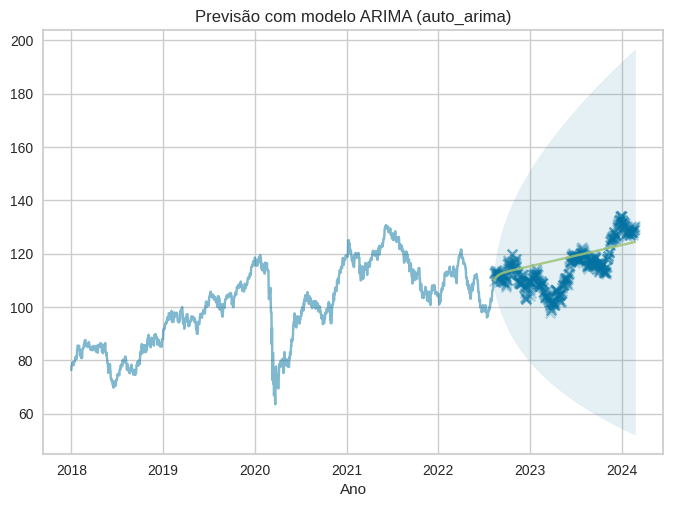

In [31]:
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = close_df.index

plt.plot(x_years[x_axis[: train.shape[0]]], train, alpha=0.5)
plt.plot(x_years[x_axis[train.shape[0] :]], preds, alpha=0.85)  # Forecasts
plt.scatter(
    x_years[x_axis[train.shape[0] :]], test, alpha=0.25, marker="x"
)  # Test data
plt.fill_between(
    x_years[x_axis[-preds.shape[0] :]],
    conf_int[:, 0],
    conf_int[:, 1],
    alpha=0.1,
    color="b",
)
plt.title("Previsão com modelo ARIMA (auto_arima)")
plt.xlabel("Ano")


# Modelo prophet

In [32]:
df_prophet = close_df.copy().reset_index().rename({"Close": "y", "Data": "ds"}, axis=1)
df_prophet.head()


ds       y
0 2018-01-01  76.402
1 2018-01-02  77.891
2 2018-01-03  77.995
3 2018-01-04  78.647
4 2018-01-05  79.071

In [33]:
train_data = df_prophet.sample(frac=TRAIN_PERC, random_state=0)
test_data = df_prophet.drop(train_data.index)

print(
    f"Quantidade de dias para teste: {test_data.shape[0]} \nQuantidade de dias para treino: {train_data.shape[0]}"
)


Quantidade de dias para teste: 561 
Quantidade de dias para treino: 1684


In [34]:
train_data.tail()


ds        y
100  2018-04-11   85.246
1270 2021-06-24  129.514
1934 2023-04-19  103.913
741  2020-01-12  115.503
334  2018-12-01   89.504

In [35]:
prophet_model = Prophet(
    daily_seasonality=True,
    changepoint_prior_scale=0.9,
    n_changepoints=5,
    interval_width=0.95,
    seasonality_mode="multiplicative",
)
prophet_model.fit(train_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmper4rslv1/hm1dtcov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmper4rslv1/sku41l6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/juno/.cache/pypoetry/virtualenvs/tech-challenge-fase02-KEHhlouW-py3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65664', 'data', 'file=/tmp/tmper4rslv1/hm1dtcov.json', 'init=/tmp/tmper4rslv1/sku41l6x.json', 'output', 'file=/tmp/tmper4rslv1/prophet_modelpa4qrx46/prophet_model-20240302184733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


18:47:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
dataFramefuture = prophet_model.make_future_dataframe(periods=30, freq="D")
prophet_forecast = prophet_model.predict(dataFramefuture)
prophet_forecast.tail()


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1709 2024-03-20  23.511392  107.530535  137.850330    23.492184    23.516995   
1710 2024-03-21  23.519723  106.261814  138.134802    23.493105    23.528766   
1711 2024-03-22  23.528055  106.338830  136.688623    23.497981    23.545162   
1712 2024-03-23  23.536386  106.571297  137.235420    23.504558    23.559550   
1713 2024-03-24  23.544718  106.411955  138.822330    23.511274    23.580276   

       daily  daily_lower  daily_upper  multiplicative_terms  ...    weekly  \
1709  4.3914       4.3914       4.3914              4.208713  ...  0.012510   
1710  4.3914       4.3914       4.3914              4.189202  ... -0.003966   
1711  4.3914       4.3914       4.3914              4.185210  ... -0.006188   
1712  4.3914       4.3914       4.3914              4.184617  ... -0.006195   
1713  4.3914       4.3914       4.3914              4.198504  ...  0.007184   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
1709      0.012510      0.012510 -0.195197     -0.195197     -0.195197   
1710     -0.003966     -0.003966 -0.198232     -0.198232     -0.198232   
1711     -0.006188     -0.006188 -0.200003     -0.200003     -0.200003   
1712     -0.006195     -0.006195 -0.200588     -0.200588     -0.200588   
1713      0.007184      0.007184 -0.200080     -0.200080     -0.200080   

      additive_terms  additive_terms_lower  additive_terms_upper        yhat  
1709             0.0                   0.0                   0.0  122.464099  
1710             0.0                   0.0                   0.0  122.048605  
1711             0.0                   0.0                   0.0  121.997894  
1712             0.0                   0.0                   0.0  122.027145  
1713             0.0                   0.0                   0.0  122.397302  

[5 rows x 22 columns]

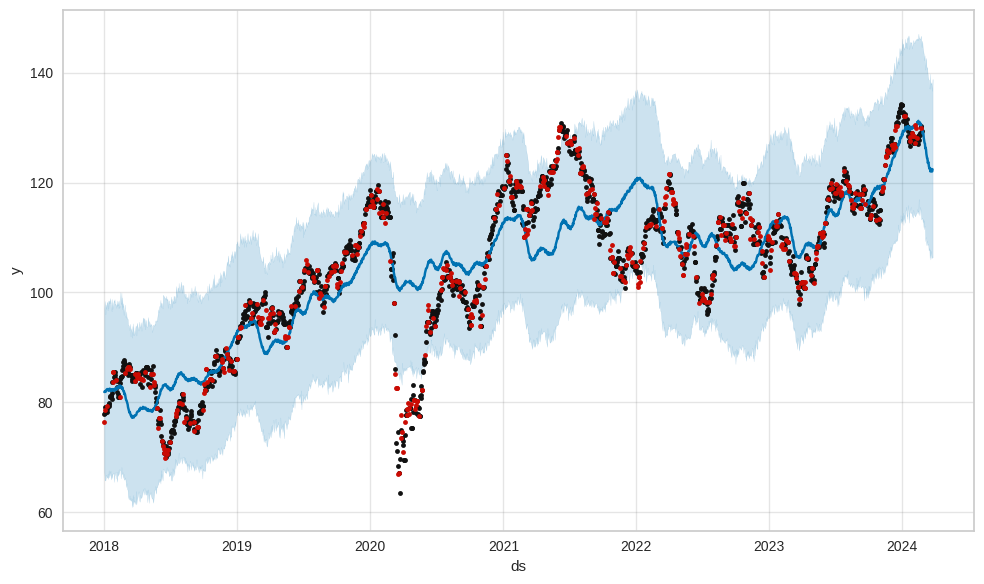

In [37]:
prophet_model.plot(prophet_forecast)
plt.plot(test_data["ds"], test_data["y"], ".r")


In [38]:
prophet_forecast


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2018-01-02  14.480204   67.338006   97.092940    14.480204    14.480204   
1    2018-01-03  14.485389   65.868280   98.427899    14.485389    14.485389   
2    2018-01-05  14.495760   65.778379   96.020924    14.495760    14.495760   
3    2018-01-06  14.500946   66.345583   97.805586    14.500946    14.500946   
4    2018-01-07  14.506132   66.829719   97.026846    14.506132    14.506132   
...         ...        ...         ...         ...          ...          ...   
1709 2024-03-20  23.511392  107.530535  137.850330    23.492184    23.516995   
1710 2024-03-21  23.519723  106.261814  138.134802    23.493105    23.528766   
1711 2024-03-22  23.528055  106.338830  136.688623    23.497981    23.545162   
1712 2024-03-23  23.536386  106.571297  137.235420    23.504558    23.559550   
1713 2024-03-24  23.544718  106.411955  138.822330    23.511274    23.580276   

       daily  daily_lower  daily_upper  multiplicative_terms  ...    weekly  \
0     4.3914       4.3914       4.3914              4.654352  ...  0.009559   
1     4.3914       4.3914       4.3914              4.661451  ...  0.012510   
2     4.3914       4.3914       4.3914              4.649622  ... -0.006188   
3     4.3914       4.3914       4.3914              4.652277  ... -0.006195   
4     4.3914       4.3914       4.3914              4.667773  ...  0.007184   
...      ...          ...          ...                   ...  ...       ...   
1709  4.3914       4.3914       4.3914              4.208713  ...  0.012510   
1710  4.3914       4.3914       4.3914              4.189202  ... -0.003966   
1711  4.3914       4.3914       4.3914              4.185210  ... -0.006188   
1712  4.3914       4.3914       4.3914              4.184617  ... -0.006195   
1713  4.3914       4.3914       4.3914              4.198504  ...  0.007184   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0         0.009559      0.009559  0.253393      0.253393      0.253393   
1         0.012510      0.012510  0.257540      0.257540      0.257540   
2        -0.006188     -0.006188  0.264410      0.264410      0.264410   
3        -0.006195     -0.006195  0.267072      0.267072      0.267072   
4         0.007184      0.007184  0.269190      0.269190      0.269190   
...            ...           ...       ...           ...           ...   
1709      0.012510      0.012510 -0.195197     -0.195197     -0.195197   
1710     -0.003966     -0.003966 -0.198232     -0.198232     -0.198232   
1711     -0.006188     -0.006188 -0.200003     -0.200003     -0.200003   
1712     -0.006195     -0.006195 -0.200588     -0.200588     -0.200588   
1713      0.007184      0.007184 -0.200080     -0.200080     -0.200080   

      additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0                0.0                   0.0                   0.0   81.876173  
1                0.0                   0.0                   0.0   82.008314  
2                0.0                   0.0                   0.0   81.895568  
3                0.0                   0.0                   0.0   81.963358  
4                0.0                   0.0                   0.0   82.217467  
...              ...                   ...                   ...         ...  
1709             0.0                   0.0                   0.0  122.464099  
1710             0.0                   0.0                   0.0  122.048605  
1711             0.0                   0.0                   0.0  121.997894  
1712             0.0                   0.0                   0.0  122.027145  
1713             0.0                   0.0                   0.0  122.397302  

[1714 rows x 22 columns]

In [59]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=prophet_forecast["ds"],
        y=prophet_forecast["yhat"],
        mode="markers",
        name="yhat",
    )
)
fig.add_trace(go.Scatter(x=test_data["ds"], y=test_data["y"], mode="lines", name="y"))
fig.add_trace(
    go.Scatter(
        x=prophet_forecast["ds"],
        y=prophet_forecast["yhat_lower"],
        mode="lines",
        name="lower",
    )
)
fig.add_trace(
    go.Scatter(
        x=prophet_forecast["ds"],
        y=prophet_forecast["yhat_upper"],
        mode="lines",
        name="upper",
    )
)
fig.update_layout(title="Prophet - Dados de previsão e teste", width=1000, height=600)
fig.show()


In [54]:
from prophet.plot import plot_components_plotly
from prophet.plot import plot_components


plot_components_plotly(prophet_model, prophet_forecast)


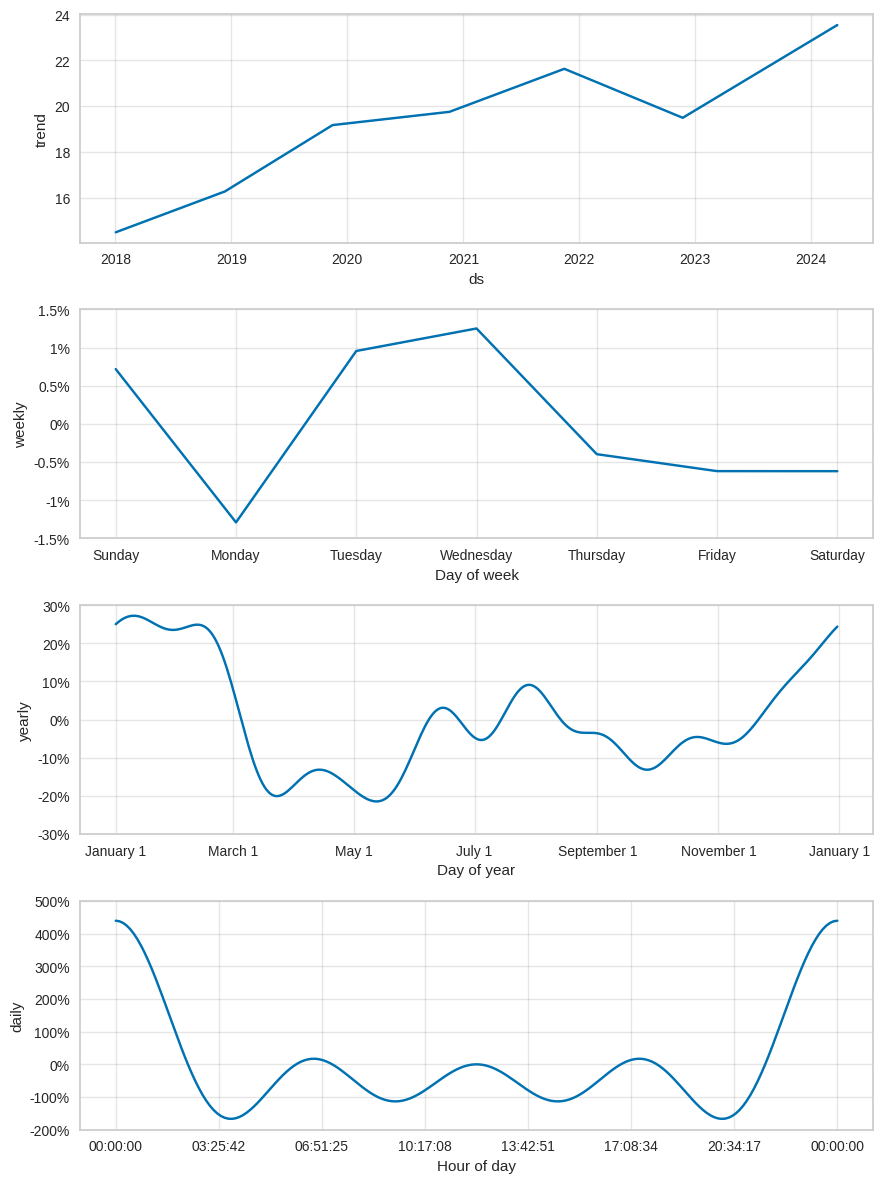

In [56]:
plot_components(prophet_model, prophet_forecast)


In [364]:
from prophet.plot import add_changepoints_to_plot

prophet_changepoints = Prophet(  # changepoint_range=0.9,
    n_changepoints=12, daily_seasonality=True
)
prophet_changepoints.fit(train_data)
dataFramefuture = prophet_changepoints.make_future_dataframe(periods=30, freq="D")
forecast_changepoints = prophet_changepoints.predict(dataFramefuture)
forecast_changepoints.tail()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1efqfmc7/6jxzkv6h.json


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1efqfmc7/4vls6ly3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/juno/.cache/pypoetry/virtualenvs/tech-challenge-fase02-KEHhlouW-py3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12196', 'data', 'file=/tmp/tmp1efqfmc7/6jxzkv6h.json', 'init=/tmp/tmp1efqfmc7/4vls6ly3.json', 'output', 'file=/tmp/tmp1efqfmc7/prophet_modelm_xwnt_y/prophet_model-20240302154214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1709 2024-03-20  123.774569  114.297553  128.995406   123.774569   123.774569   
1710 2024-03-21  123.812917  114.383273  129.498056   123.812917   123.812917   
1711 2024-03-22  123.851264  113.845329  128.853371   123.851264   123.851264   
1712 2024-03-23  123.889611  114.205681  128.885947   123.889611   123.889611   
1713 2024-03-24  123.927959  113.297089  128.455041   123.927959   123.927959   

      additive_terms  additive_terms_lower  additive_terms_upper    daily  \
1709       -2.089016             -2.089016             -2.089016  1.95942   
1710       -2.279569             -2.279569             -2.279569  1.95942   
1711       -2.371136             -2.371136             -2.371136  1.95942   
1712       -2.434679             -2.434679             -2.434679  1.95942   
1713       -2.611510             -2.611510             -2.611510  1.95942   

      ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
1709  ...  0.035751      0.035751      0.035751 -4.084187     -4.084187   
1710  ...  0.005896      0.005896      0.005896 -4.244886     -4.244886   
1711  ...  0.046474      0.046474      0.046474 -4.377030     -4.377030   
1712  ...  0.086271      0.086271      0.086271 -4.480371     -4.480371   
1713  ... -0.015909     -0.015909     -0.015909 -4.555022     -4.555022   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
1709     -4.084187                   0.0                         0.0   
1710     -4.244886                   0.0                         0.0   
1711     -4.377030                   0.0                         0.0   
1712     -4.480371                   0.0                         0.0   
1713     -4.555022                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
1709                         0.0  121.685554  
1710                         0.0  121.533347  
1711                         0.0  121.480128  
1712                         0.0  121.454933  
1713                         0.0  121.316449  

[5 rows x 22 columns]

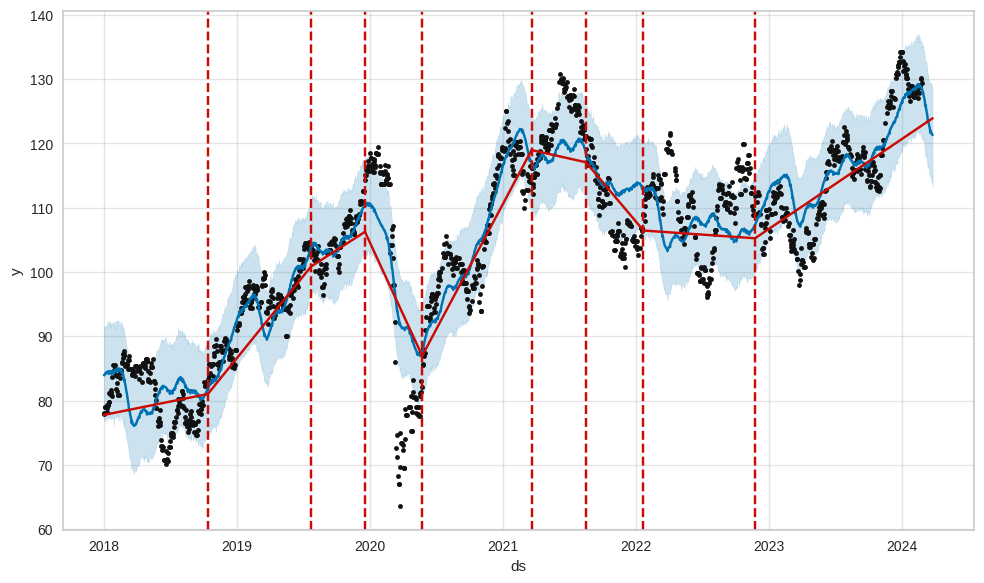

In [365]:
fig = prophet_changepoints.plot(forecast_changepoints)
a = add_changepoints_to_plot(fig.gca(), prophet_changepoints, forecast_changepoints)


In [366]:
prophet_changepoints.changepoints


112    2018-05-21
224    2018-10-14
336    2019-03-02
449    2019-07-24
561    2019-12-19
673    2020-05-24
785    2020-10-20
897    2021-03-20
1010   2021-08-16
1122   2022-01-21
1234   2022-06-24
1346   2022-11-23
Name: ds, dtype: datetime64[ns]

In [369]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ["ds", "yhat"]
valores_reais_cols = ["ds", "y"]

previsao = prophet_forecast[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on="ds", how="inner")

# Print the error:
rmse = np.sqrt(mean_squared_error(resultados["y"], resultados["yhat"]))
print(f"Test RMSE: {rmse:.2f}")
mape = mean_absolute_percentage_error(resultados["y"], resultados["yhat"]) * 100
print(f"Test MAPE: {mape:.2f}%")
mae = mean_absolute_error(resultados["y"], resultados["yhat"])
print(f"Test MAE: {mae:.2f}")


Test RMSE: 7.98
Test MAPE: 6.17%
Test MAE: 6.12


### Cross-Validation

Período de 30 dias

In [82]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(
    prophet_model, initial="730 days", period="180 days", horizon="30 days"
)


INFO:prophet:Making 9 forecasts with cutoffs between 2020-02-14 00:00:00 and 2024-01-24 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmper4rslv1/wf4qn7l_.json


DEBUG:cmdstanpy:input tempfile: /tmp/tmper4rslv1/kka56bvq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/juno/.cache/pypoetry/virtualenvs/tech-challenge-fase02-KEHhlouW-py3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28872', 'data', 'file=/tmp/tmper4rslv1/wf4qn7l_.json', 'init=/tmp/tmper4rslv1/kka56bvq.json', 'output', 'file=/tmp/tmper4rslv1/prophet_modelb2xz5_j6/prophet_model-20240302192633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:26:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmper4rslv1/3n8o2zla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmper4rslv1/sma6cab3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/ju

In [83]:
df_cv.head()


ds        yhat  yhat_lower  yhat_upper        y     cutoff
0 2020-02-15  114.477636  109.859741  118.960555  114.381 2020-02-14
1 2020-02-16  114.203155  109.325293  118.912901  114.381 2020-02-14
2 2020-02-17  113.993526  108.935902  118.342306  115.309 2020-02-14
3 2020-02-18  114.328840  109.957435  118.780607  114.977 2020-02-14
4 2020-02-19  113.930614  109.045010  118.657252  116.518 2020-02-14

In [84]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p


horizon         mse       rmse        mae      mape     mdape     smape  \
0   3 days   20.147158   4.488559   3.659196  0.032689  0.023070  0.033348   
1   4 days   27.576464   5.251330   4.418741  0.039693  0.044010  0.040556   
2   5 days   34.394687   5.864698   5.267635  0.047390  0.047827  0.048412   
3   6 days   40.757962   6.384196   5.780533  0.052054  0.050609  0.053127   
4   7 days   40.464607   6.361180   5.674931  0.050862  0.052826  0.051742   
5   8 days   46.006928   6.782841   5.828201  0.052257  0.052826  0.053479   
6   9 days   50.433646   7.101665   6.081125  0.054388  0.052958  0.055935   
7  10 days   52.076270   7.216389   6.118969  0.055000  0.054832  0.056747   
8  11 days   61.252108   7.826373   6.564280  0.058921  0.060007  0.060606   
9  12 days   66.181008   8.135171   6.920380  0.062279  0.070210  0.063757   
10 13 days   83.736738   9.150778   7.976074  0.071432  0.073467  0.072778   
11 14 days   88.942708   9.430944   8.406231  0.075565  0.079471  0.076809   
12 15 days   88.882383   9.427745   8.180113  0.073935  0.078955  0.075509   
13 16 days   78.441029   8.856694   7.643341  0.069508  0.078955  0.070867   
14 17 days   77.302237   8.792169   7.519281  0.068478  0.077118  0.070287   
15 18 days   73.429696   8.569113   7.440233  0.067262  0.075078  0.068861   
16 19 days   79.392330   8.910237   7.759020  0.069752  0.068353  0.071754   
17 20 days   67.739117   8.230378   7.121007  0.064139  0.057786  0.065117   
18 21 days   82.137129   9.062954   7.900250  0.071600  0.057510  0.072238   
19 22 days   90.367919   9.506204   8.150629  0.074364  0.059214  0.074510   
20 23 days  103.607678  10.178786   8.531957  0.077055  0.059214  0.078502   
21 24 days  120.190720  10.963153   8.516559  0.080065  0.074478  0.080302   
22 25 days  126.595922  11.251485   8.897287  0.085132  0.073108  0.084235   
23 26 days  127.382313  11.286377   9.262222  0.088766  0.078454  0.087265   
24 27 days  182.966046  13.526494  10.593107  0.107552  0.078454  0.101296   
25 28 days  164.783924  12.836819   9.950332  0.099716  0.081354  0.094512   
26 29 days  155.049661  12.451894   9.237016  0.092237  0.079643  0.087568   
27 30 days   83.176086   9.120092   7.424367  0.066794  0.071796  0.068159   

    coverage  
0   1.000000  
1   1.000000  
2   1.000000  
3   1.000000  
4   1.000000  
5   1.000000  
6   1.000000  
7   1.000000  
8   0.950000  
9   0.900000  
10  0.756250  
11  0.708333  
12  0.714286  
13  0.775000  
14  0.750000  
15  0.737500  
16  0.733333  
17  0.783333  
18  0.771429  
19  0.700000  
20  0.650000  
21  0.642857  
22  0.664286  
23  0.635714  
24  0.643750  
25  0.650000  
26  0.710000  
27  0.750000

# Modelo pycaret


In [104]:
train_df = close_df.iloc[: int(close_df.shape[0] * TRAIN_PERC) - 1]
test_df = close_df.drop(train_df.index)
# int(close_df.shape[0]*TRAIN_PERC)


In [106]:
train_df.tail()


Close
Data               
2022-08-05  106.472
2022-08-06  106.472
2022-08-07  106.472
2022-08-08  108.402
2022-08-09  108.651

In [151]:
# parâmetros para o modelo
fh = test_df.shape[0]
fold = 2
fig_kwargs = {
    "renderer": "png",  # png ou svg
    "height": 600,  # altura da imagem
    "width": 1000,
    "template": "simple_white",
}
exp = TSForecastingExperiment()

exp.setup(
    data=close_df,
    fh=fh,
    session_id=42,
    fig_kwargs=fig_kwargs,
    use_gpu=True,
    fold=fold,
    # log_experiment=True,
    seasonality_type="add",
    # seasonal_period=["W", "M"],
    hyperparameter_split="train",
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

In [147]:
from sklearn.metrics import mean_squared_error

exp.add_metric("mean_squared_error", "MSE", mean_squared_error, greater_is_better=False)


Name                                                               MSE
Display Name                                                       MSE
Score Function         <function mean_squared_error at 0x7fb1db407600>
Scorer               make_scorer(mean_squared_error, greater_is_bet...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: mean_squared_error, dtype: object

## Checando a série de tempo

## Dividindo conjunto entre Treino e Teste

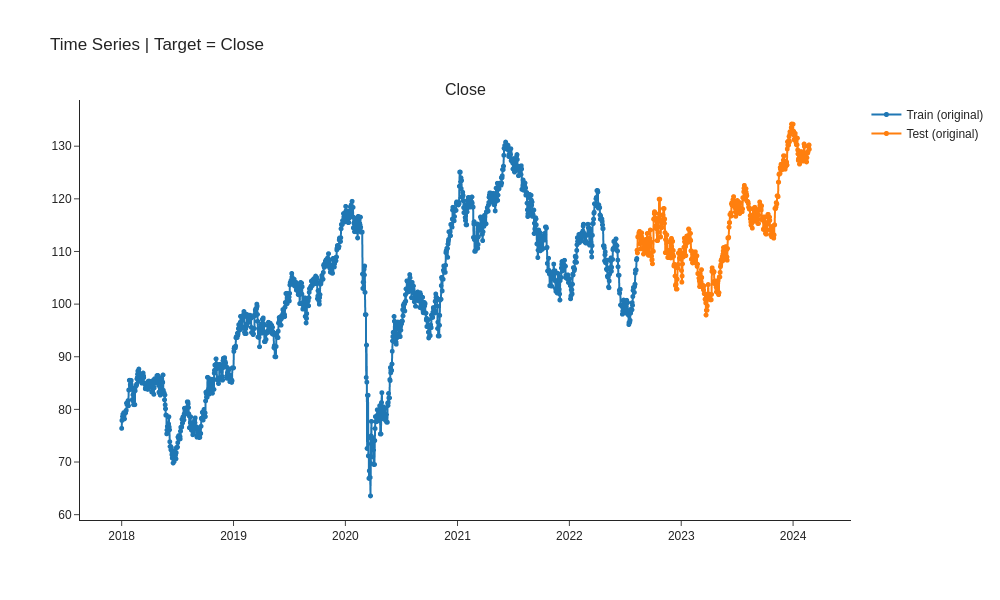

In [148]:
exp.plot_model(plot="train_test_split", fig_kwargs=fig_kwargs)


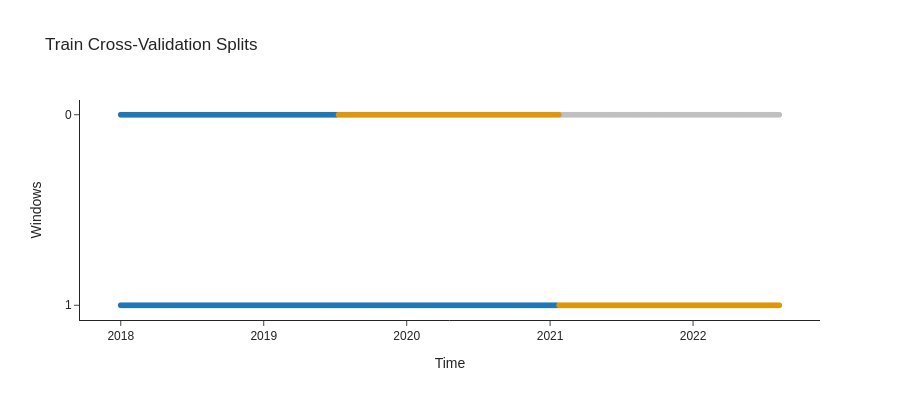

In [134]:
exp.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})


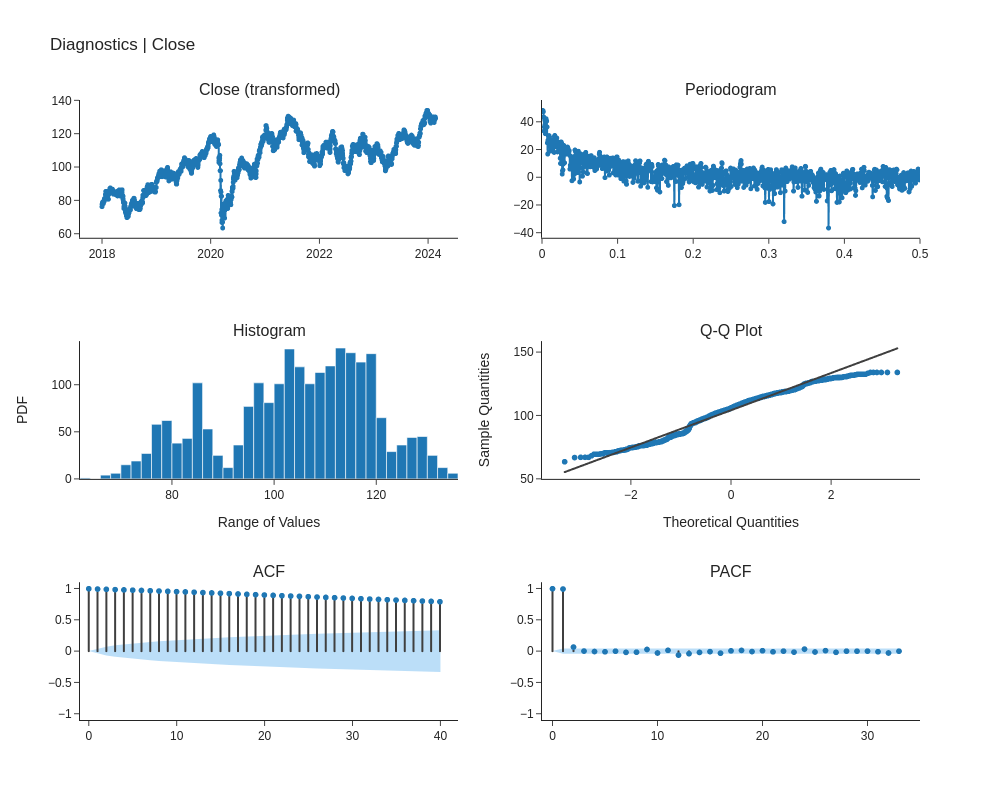

In [135]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})


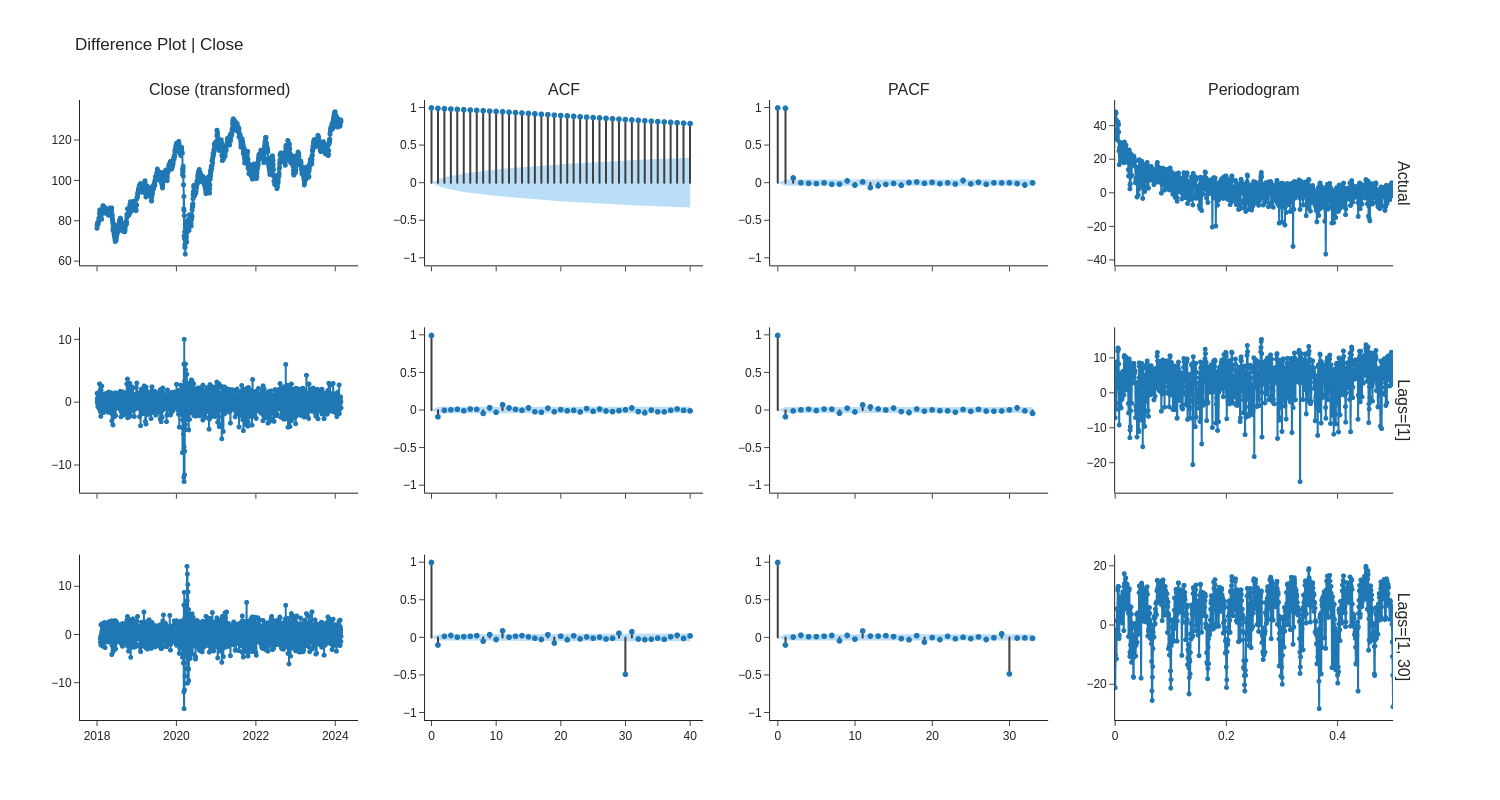

In [136]:
exp.plot_model(
    plot="diff",
    data_kwargs={
        "lags_list": [[1], [1, 30]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    fig_kwargs={"height": 800, "width": 1500},
)


In [ ]:
exp.plot_model(plot="decomp", fig_kwargs={"height": 500})


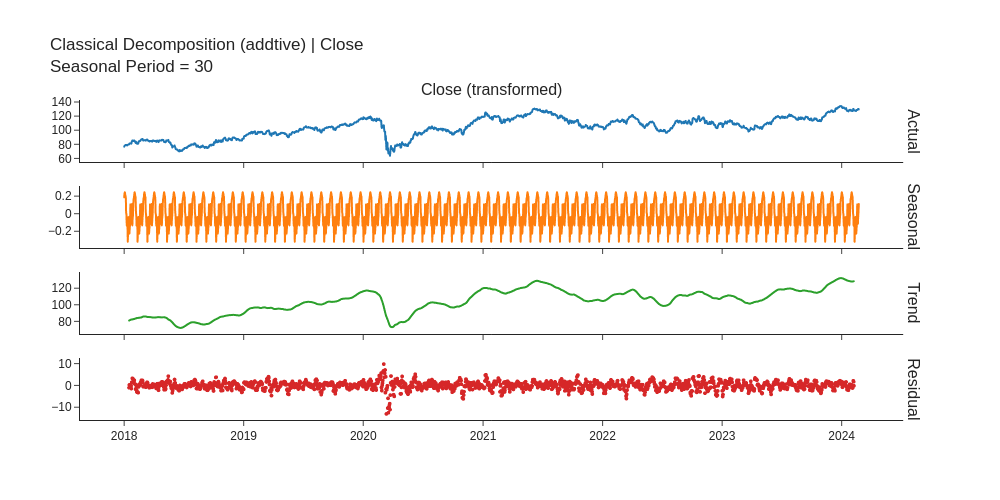

In [137]:
# Users may wish to customize the decomposition, for example, in this case multiplicative seasonality
# probably makes more sense since the magnitide of the seasonality increase as the time progresses
exp.plot_model(
    plot="decomp",
    data_kwargs={"type": "addtive", "seasonal_period": 30},
    fig_kwargs={"height": 500},
)


## Statistical tests

In [122]:
exp.check_stats()


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   2245.0  
1                                      0.0  
2                               104.304033  
3                                  106.042  
4                                14.722484  
5                               216.751534  
6                                 -0.56507  
7                                -0.402181  
8                                   1500.0  
9   {'alpha': 0.05, 'K': 24}  47861.176532  
10  {'alpha': 0.05, 'K': 48}  83923.149051  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}           0.0  
14  {'alpha': 0.05, 'K': 48}           0.0  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.204447  
17           {'alpha': 0.05}      -2.20497  
18           {'alpha': 0.05}     -3.433283  
19           {'alpha': 0.05}     -2.862836  
20           {'alpha': 0.05}      -2.56746  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}      0.413226  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

## Modelo

In [123]:
exp.get_metrics()


Name Display Name  \
ID                                       
mase                 MASE         MASE   
rmsse               RMSSE        RMSSE   
mae                   MAE          MAE   
rmse                 RMSE         RMSE   
mape                 MAPE         MAPE   
smape               SMAPE        SMAPE   
r2                     R2           R2   
mean_squared_error    MSE          MSE   

                                                      Score Function  \
ID                                                                     
mase                               <function mase at 0x7fb1d9cf9080>   
rmsse                             <function rmsse at 0x7fb1d9cf9120>   
mae                 <function mean_absolute_error at 0x7fb1db407240>   
rmse                 <function mean_squared_error at 0x7fb1db407600>   
mape                               <function mape at 0x7fb1d9cf8fe0>   
smape                       <function _smape_loss at 0x7fb1d9da8180>   
r2                             <function r2_score at 0x7fb1db407e20>   
mean_squared_error   <function mean_squared_error at 0x7fb1db407600>   

                                                               Scorer Target  \
ID                                                                             
mase                make_scorer(mase, greater_is_better=False, res...   pred   
rmsse               make_scorer(rmsse, greater_is_better=False, re...   pred   
mae                                           neg_mean_absolute_error   pred   
rmse                                      neg_root_mean_squared_error   pred   
mape                make_scorer(mape, greater_is_better=False, res...   pred   
smape               make_scorer(_smape_loss, greater_is_better=Fal...   pred   
r2                                                                 r2   pred   
mean_squared_error  make_scorer(mean_squared_error, greater_is_bet...   pred   

                                  Args  Greater is Better  Custom  
ID                                                                 
mase                                {}              False   False  
rmsse                               {}              False   False  
mae                                 {}              False   False  
rmse                {'squared': False}              False   False  
mape                                {}              False   False  
smape                               {}              False   False  
r2                                  {}               True   False  
mean_squared_error                  {}              False    True

In [150]:
best = exp.compare_models(
    include=[
        "bats",
        "tbats",
        "theta",
        "naive",
        "snaive",
        "polytrend",
        "xgboost_cds_dt",
        "dt_cds_dt",
        "en_cds_dt",
        "lasso_cds_dt",
        "br_cds_dt",
    ],
    n_select=3,
    sort="MAPE",
)
# best = exp.compare_models(n_select=5, sort="MAPE")


Initiated  . . . . . . . . . . . . . . . . . .         20:55:54
Status     . . . . . . . . . . . . . . . . . .  Fitting 2 Folds
Estimator  . . . . . . . . . . . . . . . . . .            TBATS

Processing:   0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [145]:
from pycaret.time_series import predict_model

holdout_pred = exp.predict_model(best[0])


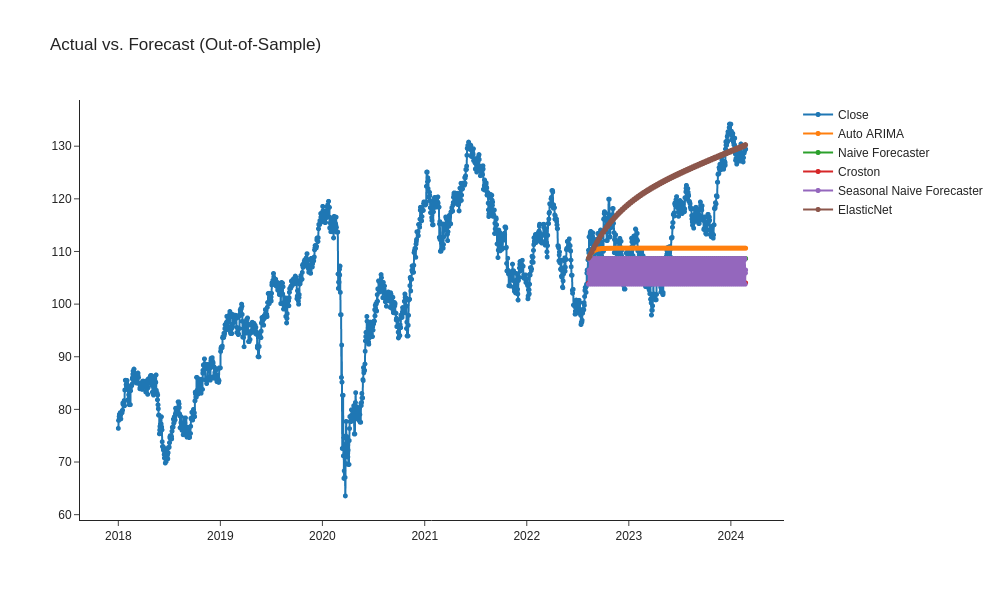

In [142]:
exp.plot_model(best)


In [ ]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09  # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

close_df["Smoothed_Close"] = close_df["Close"].ewm(alpha=alpha, adjust=False).mean()


In [ ]:
close_df.head()


In [ ]:
close_df[["Close", "Smoothed_Close"]].plot()


In [ ]:
exp3 = TSForecastingExperiment()
exp3.setup(
    data="Smoothed_Close",
    target="Smoothed_Close",
    fh=fh,
    session_id=42,
    fig_kwargs=fig_kwargs,
    use_gpu=True,
    fold=fold,
    verbose=False,
)


In [ ]:
best = exp3.compare_models(n_select=5)


# Modelo LSTM